In [30]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')
    !pip install torchaudio
    !pip install wandb --upgrade
    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    root = "/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project"
else:
    print("Running local")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"
    root_path = "/media/mirp_ai/Seagate Desktop Drive/Jaguas_2018"


Running local


In [31]:
import os
import numpy as np

import datetime
from datetime import timedelta

import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from Jaguas_DataLoader_rainless import SoundscapeData

import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [32]:
class df_generator():
    def __init__(self, root_clusters, root_audios, root_recorders, n_clusters_index = 0):
        self.n_clusters_index = n_clusters_index
        self.cluster_names = os.listdir(f"{root_clusters}")
        self.torch_clusters = torch.load(f"{root_clusters}/{self.cluster_names[n_clusters_index]}")
        self.dataframe_clusters = pd.DataFrame(self.torch_clusters)
        self.dataframe_clusters = self.dataframe_clusters.transpose()
        self.dataframe_audios = pd.read_csv(f"{root_audios}", index_col=0)
        self.dataframe_recorders = pd.read_csv(f"{root_recorders}",sep = ";", index_col = "Recorder")
        self.df_clusters_len = len(self.dataframe_clusters)
        self.df_recorders_len = len(self.dataframe_recorders)
        self.n_clusters = np.arange(len(self.torch_clusters))

    def show_clusters(self):
        for i in range(len(self.cluster_names)):
            print(f"{i}: {self.cluster_names[i]}")

    def init_clusters(self):
        for cluster in self.n_clusters:
            self.dataframe_recorders[f"Cluster {cluster}"] = 0
    
    def create_clusters(self, count_cluster=False):
        self.init_clusters()
        for cluster in self.n_clusters:
            for i in range(self.df_clusters_len):  
                if self.dataframe_clusters.iloc[i][cluster] != None:
                    self.dataframe_recorders.loc[self.dataframe_clusters.iloc[i][cluster].split("_")[0], f"Cluster {cluster}"] +=1
                else:
                    pass
        if count_cluster == True:
            self.count_cluster_data()
        else:
            pass
        
        return self.dataframe_recorders
    
    def count_cluster_data(self):
        self.dataframe_recorders["Total_Clustering_Audios"] = 0
        for recorder in range(self.df_recorders_len):
            clusters = [f"Cluster {i}" for i in range(0, len(self.n_clusters))]
            clusters.append("Total_Clustering_Audios")
            self.dataframe_recorders.iloc[recorder, -1] = self.dataframe_recorders[clusters].iloc[recorder].sum()
    
    def GLM_dataframe(self):
        GLM = self.dataframe_recorders.copy()
        columns = [f"Cluster {i}" for i in range(0, len(self.n_clusters))]
        columns.append("Total_Clustering_Audios")
        GLM = GLM[columns]
        for cluster in range(len(columns[0:-1])):
            for recorder in range(self.df_recorders_len):
                GLM.iloc[recorder, cluster] = GLM.iloc[recorder, cluster]/GLM.iloc[recorder, -1]
        return GLM
    
    def regions(self):
        self.dataframe_audios["Region"] = 0
        for audio in range(len(self.dataframe_audios)):   
            self.dataframe_audios.loc[audio,"Region"] = self.dataframe_recorders.loc[self.dataframe_audios.loc[audio, "Recorder"]].loc["Region"]
        return self.dataframe_audios
    
    def save(self, root_save=None):
        if root_save != None:
            os.makedirs(f"{self.root_save}/dataframes", exist_ok=True)
            self.dataframe_recorders.to_csv(f"{self.root_save}/dataframes/dataframe_{self.cluster_names[self.n_clusters_index]}_recorders.csv")
            self.dataframe_recorders.to_csv(f"{self.root_save}/dataframes/dataframe_{self.cluster_names[self.n_clusters_index]}_audios.csv") 
            
        else:
            self.dataframe_recorders.to_csv(f"{self.cluster_names[sel.n_clusters_index]}_recorders.csv")
            self.dataframe_audios.to_csv(f"{self.cluster_names[sel.n_clusters_index]}_audios.csv")            

In [33]:
root_audios = f"{root}/Jaguas/Complementary_Files/Audios_Jaguas/Audios_Jaguas.csv"
root_recorders = f"{root}/Jaguas/Complementary_Files/df_grabadoras_reg.csv"
root_clusters = f"{root}/Jaguas/temporal/clusters"
ecological_integrity = f"{root}/Jaguas/Complementary_Files/Indice_Integridad_Ecologica.xlsx"
df_EI = pd.read_excel(ecological_integrity)

In [11]:
dataframe = df_generator(root_clusters, root_audios, root_recorders, 
                         n_clusters_index=12)
dataframe.create_clusters(count_cluster=True)
GLM = dataframe.GLM_dataframe()
GLM = GLM.reset_index().set_index(np.arange(len(GLM)))
GLM["Mean"] = df_EI["Mean"]
GLM["Sum"] = df_EI["Sum"]
GLM["Max"] = df_EI["Max"]
GLM["Min"] = df_EI["Min"]
# GLM

In [23]:
cl_names = os.listdir(f"{root_clusters}")
clusters = torch.load(f"{root_clusters}/{cl_names[21]}")

[array(['G03_20180512_083200.wav', 'G03_20180512_090400.wav',
        'G03_20180512_090400.wav', ..., 'G58_20180629_074500.wav',
        'G58_20180629_074500.wav', 'G58_20180629_074500.wav'], dtype='<U23'),
 array(['G03_20180512_090400.wav', 'G03_20180512_090400.wav',
        'G03_20180512_095200.wav', ..., 'G58_20180703_194500.wav',
        'G58_20180703_194500.wav', 'G58_20180703_194500.wav'], dtype='<U23'),
 array(['G03_20180511_224000.wav', 'G03_20180511_224000.wav',
        'G03_20180511_224000.wav', ..., 'G58_20180703_180000.wav',
        'G58_20180703_180000.wav', 'G58_20180704_050000.wav'], dtype='<U23'),
 array(['G03_20180515_112800.wav', 'G03_20180512_181500.wav',
        'G03_20180512_181500.wav', ..., 'G58_20180703_184500.wav',
        'G58_20180703_184500.wav', 'G58_20180703_184500.wav'], dtype='<U23'),
 array(['G03_20180512_145600.wav', 'G03_20180512_152800.wav',
        'G03_20180512_152800.wav', ..., 'G58_20180629_154400.wav',
        'G58_20180629_160000.wav', 'G58_201

In [93]:
path = path.astype("U16")

array(['a', 'a', 'a', 'a', 'a'], dtype='<U16')

In [95]:
path = ["a"]
path = np.asarray(path, dtype="U16")
path = np.repeat(path, 5) 
identifier = ["_1","_2","_3","_4","_5"]
identifier = np.asarray(identifier)
# path = path.astype("float64")
for i in range(len(path)):
    print(path[i] + identifier[i])
    path[i] = path[i] + identifier[i]
    print(path[i]) 


a_1
a_1
a_2
a_2
a_3
a_3
a_4
a_4
a_5
a_5


In [6]:
regiones = dataframe.regions()
regiones

,Recording,Recorder,Date,Time,Filename,Municipio,Vereda,Latitud,Longitud,Elevacion,Habitat,Rain_occurrence,Rain_Intesity,Intensity_Category,Region
0,G03_20180511_120000,G03,2018/05/11,12:00:00,G03_20180511_120000.wav,Alejandria,El Respaldo,6.4137,-75.0366,1322,Forest,0,0,No_rain,1
1,G03_20180511_121600,G03,2018/05/11,12:16:00,G03_20180511_121600.wav,Alejandria,El Respaldo,6.4137,-75.0366,1322,Forest,0,0,No_rain,1
2,G03_20180511_123200,G03,2018/05/11,12:32:00,G03_20180511_123200.wav,Alejandria,El Respaldo,6.4137,-75.0366,1322,Forest,0,0,No_rain,1
3,G03_20180511_124800,G03,2018/05/11,12:48:00,G03_20180511_124800.wav,Alejandria,El Respaldo,6.4137,-75.0366,1322,Forest,0,0,No_rain,1
4,G03_20180511_130400,G03,2018/05/11,13:04:00,G03_20180511_130400.wav,Alejandria,El Respaldo,6.4137,-75.0366,1322,Forest,0,0,No_rain,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20063,G58_20180704_070000,G58,2018/07/04,07:00:00,G58_20180704_070000.wav,San Rafael,Area proteccion embalse EPM,6.3471,-74.9696,1072,Forest,0,0,No_rain,12
20064,G58_20180704_064500,G58,2018/07/04,06:45:00,G58_20180704_064500.wav,San Rafael,Area proteccion embalse EPM,6.3471,-74.9696,1072,Forest,0,0,No_rain,12
20065,G58_20180704_071500,G58,2018/07/04,07:15:00,G58_20180704_071500.wav,San Rafael,Area proteccion embalse EPM,6.3471,-74.9696,1072,Forest,0,0,No_rain,12
20066,G58_20180704_073000,G58,2018/07/04,07:30:00,G58_20180704_073000.wav,San Rafael,Area proteccion embalse EPM,6.3471,-74.9696,1072,Forest,0,0,No_rain,12


# Using SK-Learn

In [ ]:
from sklearn import linear_model
clf = linear_model.PoissonRegressor()
clf.fit(X,y)

In [ ]:
clf.score(X,y)

# Using StatsModels

In [7]:
dataframe.show_clusters()

0: kmeans_PCA_clustering_labels_AE_rainless_5
1: kmeans_UMAP_clustering_labels_AE_rainless_5
2: kmeans_scaled_clustering_labels_AE_rainless_5
3: kmeans_UMAP_clustering_labels_PosAE_rainless_3
4: kmeans_PCA_clustering_labels_AE_rainless_15
5: kmeans_UMAP_clustering_labels_PosAE_rainless_10
6: kmeans_PCA_clustering_labels_PosAE_rainless_10
7: kmeans_TSNE_clustering_labels_AE_rainless_10
8: kmeans_TSNE_clustering_labels_AE_rainless_5
9: kmeans_scaled_clustering_labels_AE_rainless_10
10: kmeans_PCA_clustering_labels_PosAE_rainless_5
11: kmeans_TSNE_clustering_labels_AE_rainless_3
12: kmeans_UMAP_clustering_labels_PosAE_rainless_5
13: kmeans_TSNE_clustering_labels_PosAE_rainless_15
14: kmeans_scaled_clustering_labels_AE_rainless_15
15: kmeans_TSNE_clustering_labels_PosAE_rainless_5
16: kmeans_PCA_clustering_labels_AE_rainless_10
17: kmeans_TSNE_clustering_labels_PosAE_rainless_10
18: kmeans_UMAP_clustering_labels_AE_rainless_3
19: kmeans_scaled_clustering_labels_AE_rainless_3
20: kmeans_UMA

In [ ]:
gamma_results.pseudo_rsquared()

In [8]:
PCA_index = [27, 10, 6, 23]
UMAP_index = [3, 12, 5, 21]
TSNE_index = [29, 15, 17, 13]

([<matplotlib.axis.XTick at 0x7f2c48070190>,
 [Text(0, 0, '3'), Text(1, 0, '5'), Text(2, 0, '10'), Text(3, 0, '15')])

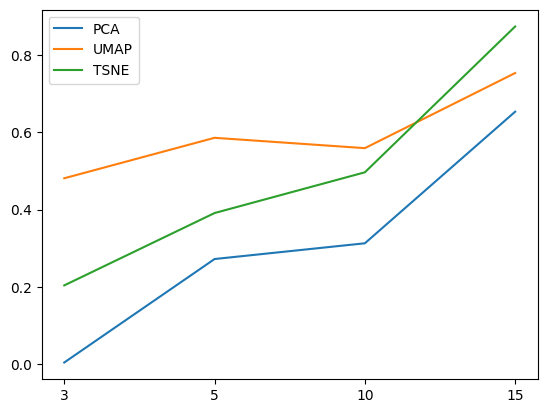

In [14]:
import matplotlib.pyplot as plt
plt.plot(r2_PCA)
plt.plot(r2_UMAP)
plt.plot(r2_TSNE)
plt.legend(["PCA", "UMAP", "TSNE"])
plt.xticks((0,1,2,3),("3", "5", "10", "15"))

In [12]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
r2_PCA = []
for index in PCA_index:
    dataframe = df_generator(root_clusters, root_audios, root_recorders, 
                         n_clusters_index=index)
    dataframe.create_clusters(count_cluster=True)
    GLM = dataframe.GLM_dataframe()
    GLM = GLM.reset_index().set_index(np.arange(len(GLM)))
    GLM["Mean"] = df_EI["Mean"]
    GLM["Sum"] = df_EI["Sum"]
    GLM["Max"] = df_EI["Max"]
    GLM["Min"] = df_EI["Min"]
    X= GLM[[f"Cluster {i}" for i in range(len(GLM.columns)-6)]]
    X = X.to_numpy()
    y = GLM["Mean"]
    y = y.to_numpy()
    gamma_model = sm.GLM(y, X, family=sm.families.Gamma())
    gamma_results = gamma_model.fit()
    r2_PCA.append(gamma_results.pseudo_rsquared())

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:307: DomainWarning: The InversePower link function does 

In [17]:
print(r2_TSNE)

[0.20378621037086753, 0.3911306338307615, 0.49659688341172126, 0.8742423457264273]


In [ ]:
import statsmodels.api as sm
X= GLM[[f"Cluster {i}" for i in range(len(GLM.columns)-6)]]
X = X.to_numpy()
y = GLM["Mean"]
y = y.to_numpy()
gamma_model = sm.GLM(y, X, family=sm.families.Gamma())
gamma_results = gamma_model.fit()
print(gamma_results.summary())

In [ ]:
import statsmodels.api as sm
data = sm.datasets.scotland.load()
data.exog = sm.add_constant(data.exog)
gamma_model = sm.GLM(data.endog, data.exog, family=sm.families.Gamma())
gamma_results = gamma_model.fit()
print(gamma_results.summary())

# SK-Learn example

In [ ]:
from sklearn import linear_model
clf = linear_model.PoissonRegressor()
X = [[1, 2], [2, 3], [3, 4], [4, 3]]
y = [12, 17, 22, 21]
clf.fit(X, y)
clf.score(X, y)
